In [ ]:
# !pip install eeglib


In [1]:
import sys
 
# setting path
sys.path.append('..')

import pandas as pd
import mne
import numpy as np
import autoreject
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import sklearn
from eeglib.features import (bandPower, hjorthActivity, hjorthMobility,
                             hjorthComplexity, sampEn, LZC, DFA, _HFD, HFD, PFD,
                             synchronizationLikelihood)
from mne_features.univariate import (compute_pow_freq_bands, compute_hjorth_mobility, 
                                     compute_hjorth_complexity, compute_higuchi_fd, compute_higuchi_fd,
                                     compute_samp_entropy)
                            

from mna.sessions.eye_session import process_session_eye
from mna.sessions.eeg_session import process_session_eeg
from mna.sessions.motor_session import process_session_motor
from mna.sessions.ecg_session import process_session_ecg

from mna.utils.batch_feature_extraction import clean_up_adadrive_trials

## 1. Read a RN App, converted pkl file, and create the metadata and data structure

In [2]:
from os import listdir
from os.path import isfile, join
from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle

In [3]:
# single subject analysis

data_dir = "../data/"
lsl_dir = "../mna/LSLPresets/"
output_dir = '../output/'
if not os.path.isdir(output_dir): os.makedirs(output_dir)

onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.pkl' in f]
input_path = data_dir + onlyfiles[8] # pick a random file
print(f"input_path {input_path}")
metadata_jsons = read_all_lslpresets(path_to_jsonfiles=lsl_dir)

preproc_ica = True

with open(input_path, 'rb') as handle:
    rns_data = pickle.load(handle)

## Add metadata to data

for key in rns_data.keys():
    rns_data[key].append(return_metadata_from_name(key, metadata_jsons))

input_path ../data/08_26_2022_11_53_52-Exp_adadrive-Sbj_12-Ssn_02.dats.pkl


## 2. Create new events (trial start etc.)

In [4]:
event_df = event_data_from_data(rns_data)
event_df['trial_damage'] = event_df.damage.diff().fillna(0)
event_df['trial_duration'] = event_df.trial_end_time - event_df.trial_start_time
percent_missing = event_df.notnull().sum() / len(event_df)
summary_statistics = {}
summary_statistics['voice_success_rate'] = percent_missing['voice_timestamp']
if 'chunk_timestamp' in percent_missing:
    summary_statistics['chunk_success_rate'] = percent_missing['chunk_timestamp']
else:
    summary_statistics['chunk_success_rate'] = 0

# temporary fix for pilot phase where we had some incomplete data
if 'block_condition' not in event_df:
    event_df['block_condition'] = 'practice'
    event_df.loc[5:,'block_condition'] = 'voice'

event_df['spoken_difficulty_encoded'] = event_df.spoken_difficulty.replace(to_replace=['easy', 'hard', 'unknown'],
                                                                      value=[1, 2, None])

In [ ]:
# Run EEG session Function

# post_processed_event_df, epochs, events, info, reject_log, ica, eog_idx= process_session_eeg(rns_data, event_df,
#                                 run_autoreject=True, run_ica=preproc_ica, template_ica = ref_ica)

## Load and filter raw EEG

In [ ]:
eeg_montage = 'biosemi64'
eeg_channel = 'BioSemi'
run_autoreject=True
autoreject_epochs=20
average_reference=True
downsampling = True
n_decim = 16
low_cut=1.
hi_cut=50.

event_column='spoken_difficulty_encoded'

event_detected = event_df[event_column].notnull()
event_recognized_df = event_df[event_detected]

eeg_channel_names = mne.channels.make_standard_montage(eeg_montage).ch_names
df = pd.DataFrame(rns_data[eeg_channel][0], columns=rns_data[eeg_channel][1],
                  index=rns_data[eeg_channel][2]['ChannelNames']).T
starting_time_s = rns_data[eeg_channel][1][0]
freq = rns_data[eeg_channel][2]['NominalSamplingRate']
rna_channel_names = list(df.columns)
rna_channel_names[1:65] = eeg_channel_names
info = mne.create_info(ch_names=rna_channel_names, ch_types=['stim'] + ['eeg'] * 64 + ['ecg'] * 2 + ['misc'] * 22,
                       sfreq=freq)
info.set_montage(eeg_montage)

raw = mne.io.RawArray(df.T * 1e-6, info)
raw = raw.pick(['eeg'])

if average_reference:
    raw = raw.set_eeg_reference(ref_channels='average')  # set average reference
if low_cut or hi_cut:
    raw.filter(l_freq=low_cut, h_freq=hi_cut, verbose=False)
if downsampling:
    raw.resample(freq/n_decim)

freq /= n_decim
    
trial_start_time = event_recognized_df.trial_start_time - starting_time_s  # reference for mne
event_values = event_recognized_df[event_column].values
events = np.column_stack((trial_start_time.values * freq,
                          np.zeros(len(event_recognized_df), dtype=int),
                          event_values)).astype(int)
event_dict = dict(easy=1, hard=2)

Creating RawArray with float64 data, n_channels=89, n_times=3891602
    Range : 0 ... 3891601 =      0.000 ...  1900.196 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


## Artifact Removal (ICA)

In [7]:
ica = mne.preprocessing.ICA(n_components=64, random_state=64)
ica.fit(raw)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 41.0s.


Method,fastica
Fit,73 iterations on raw data (243225 samples)
ICA components,64
Explained variance,100.0 %
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


In [ ]:
# ica.plot_components(picks=range(0,10))

# ica.plot_sources(epochs[:10], picks=[0,1,2,3,4,5])

### Template Matching Artifact Removal

In [8]:
if preproc_ica:

    with open('../output/saved_files/pickle_files/24_features_32_3baseline/ica_epochs.pickle', 'rb') as handle:
        all_proc_epochs = pickle.load(handle)
    with open('../output/saved_files/pickle_files/24_features_32_3baseline/ica.pickle', 'rb') as handle:
        all_ica = pickle.load(handle)
    with open('../output/saved_files/pickle_files/24_features_32_3baseline/eog_comp.pickle', 'rb') as handle:
        all_eog_comps = pickle.load(handle)
    with open('../output/saved_files/pickle_files/24_features_32_3baseline/raw_epochs.pickle', 'rb') as handle:
        all_raw_epochs = pickle.load(handle)

    ref_ica = all_ica['sbj20ssn03']
else: 
    ref_ica = None

from mne.preprocessing import corrmap

icas = [ref_ica]+[ica]
corrmap(icas, template= (0,5), label = "blink", show=False)
corrmap(icas, template= (0,4), label = "horizontal_eye_movement", show=False)
identified_ica_label = [ica.labels_ for ica in icas]
eog_idx = identified_ica_label[1]['blink']+identified_ica_label[1]['horizontal_eye_movement']

ica.apply(raw, exclude=eog_idx)

Median correlation with constructed map: 0.992
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


<RawArray | 64 x 243225 (1900.2 s), ~118.9 MB, data loaded>

In [38]:
# epochs = mne.Epochs(raw, events, event_id=event_dict, baseline = None, tmin=-0.5, tmax=3.5, preload=True, on_missing='warn')
epochs = mne.Epochs(raw, events, event_id=event_dict, baseline = None, tmin=-0.2, tmax=3, preload=True, on_missing='warn')

event_recognized_df = event_recognized_df[[e==() for e in epochs.drop_log]] # only keep good epochs in event_df

Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 49 events and 411 original time points ...
0 bad epochs dropped


### Automatic Feature Decection

In [ ]:
# # Artifact Detection
# eog_idx, eog_scores = ica.find_bads_eog(raw, ch_name = ['Fp1', 'Fp2'])
# # ecg_idx, ecg_scores = ica.find_bads_ecg(raw, method='ctps', measure='correlation', threshold="auto")
# # muscle_idx, muscle_scores = ica.find_bads_muscle(raw)

# # print([eog_idx, ecg_idx, muscle_idx])
# print([eog_idx])

# # ica.plot_scores(eog_scores, exclude=eog_idx)
# # ica.plot_scores(ecg_scores, exclude=ecg_idx)
# # ica.plot_scores(muscle_scores, exclude=muscle_idx)

# # first half all non-ECG component (EOG component was identified as ECG component as well). second half eog component
# # non_ECG_comp = list(set(np.arange(ica.n_components_)).symmetric_difference(set(ecg_idx))) + \
# #                list(set(ecg_idx).intersection(set(eog_idx)))


# # Identified Artifact Component Removal
# eeg_data_ICA = raw.copy()
# # ica.apply(eeg_data_ICA, exclude=eog_idx+ecg_idx+muscle_idx)
# # ica.apply(eeg_data_ICA, exclude=eog_idx+ecg_idx)
# ica.apply(eeg_data_ICA, exclude=eog_idx)
# # ica.apply(eeg_data_ICA, exclude=non_ECG_comp)

# eeg_data_ICA_epochs = mne.Epochs(eeg_data_ICA, events, event_id=event_dict, baseline = (None, None), tmin=-3, tmax=0, preload=True, on_missing='warn')

# del eeg_data_ICA

# # plot before and after component removal signal
# # epochs.plot(n_channels=10, n_epochs=5, show_scrollbars=False)
# # eeg_data_ICA.plot(n_channels=10, n_epochs=5, show_scrollbars=False)

## Autoreject

In [7]:
#Autoreject
if len(epochs) < 10: # we need at least 10 epochs to run autoreject for cross validation
    bad_epochs = pd.Series(np.full(len(event_df),np.NAN), index=event_df.index, name='autorejected')
    event_df = event_df.join(bad_epochs)
    reject_log = None

elif run_autoreject:
    ar = autoreject.AutoReject(random_state=11, n_jobs=2, verbose=False)
    ar.fit(epochs[:autoreject_epochs])  # fit on a few epochs to save time
    epochs_ar, reject_log = ar.transform(epochs, return_log=True)
    bad_epochs = pd.Series(reject_log.bad_epochs, index=event_recognized_df.index, dtype=bool, name='autorejected')
    event_df = event_df.join(bad_epochs) # creates nan if not processed at all
    epochs = epochs_ar

NameError: name 'epochs' is not defined

## Time-Frequency Analysis

Applying baseline correction (mode: mean)


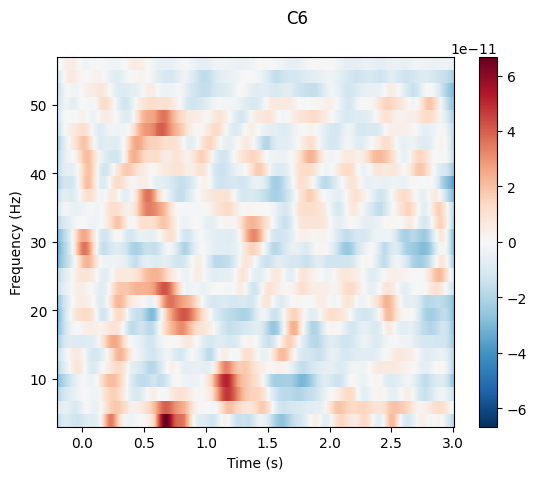

Applying baseline correction (mode: mean)


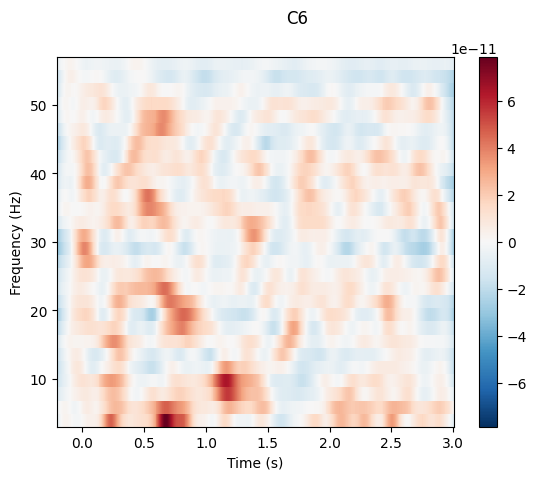

Applying baseline correction (mode: mean)


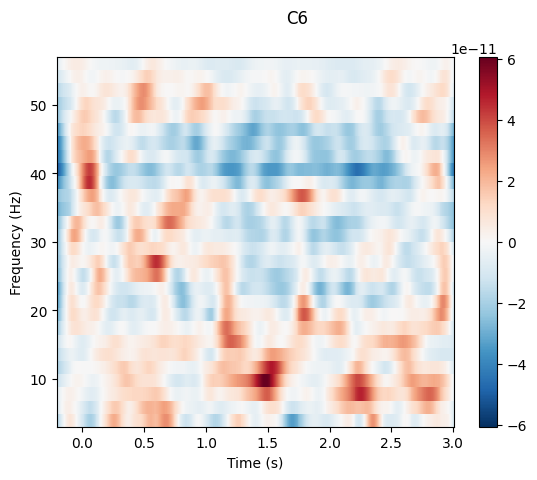

[<Figure size 640x480 with 2 Axes>]

In [53]:
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

epochs_easy = epochs['easy']
epochs_hard = epochs['hard']

# freq_range = np.logspace(*np.log10([4, 55]), num=15)
freq_range = np.linspace(4, 56, 28)
n_cycles = freq_range / 2.

power_easy, itc_easy = tfr_morlet(epochs_easy, freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=True, n_jobs=1)
power_hard, itc_hard = tfr_morlet(epochs_hard, freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=True, n_jobs=1)

sel_chan = 50

# power_easy.plot_topo(baseline=(-0.5, -.2), mode='mean', title='Average power')
power_easy.plot([sel_chan], baseline=(-0.2, .3), mode='mean', title=power_easy.ch_names[sel_chan])
power_easy.plot([sel_chan], baseline=(-0.2, 0), mode='mean', title=power_easy.ch_names[sel_chan])
# power_easy.plot([sel_chan], baseline=None, mode='mean', title=power_easy.ch_names[sel_chan])

# power_hard.plot_topo(baseline=None, mode='mean', title='Average power')
power_hard.plot([sel_chan], baseline=(-0.2, 0.3), mode='mean', title=power_hard.ch_names[sel_chan])
# power_hard.plot([sel_chan], baseline=None, mode='mean', title=power_hard.ch_names[sel_chan])


## Feature Extraction

### EEG Feature Extraction

In [ ]:
eeg_bands = {'theta': [4, 8],
    'alpha': [8, 15],
    'beta': [15, 32],
    'gamma': [32, 55]}

band_specific_epoch = {}

for freq_band in eeg_bands.keys():
    band_specific_epoch[freq_band] = np.squeeze(epochs.filter(eeg_bands[freq_band][0],eeg_bands[freq_band][1], 
                                                              verbose = False).get_data())
    # band_specific_epoch[freq_band] = epochs.filter(eeg_bands[freq_band][0],eeg_bands[freq_band][1], verbose = False)

In [ ]:
# epochs.filter(8,15, verbose = False).plot_psd()
# band_specific_epoch['alpha'].plot_psd()

# epochs.filter(8,15, verbose = False).get_data()[0].mean(), band_specific_epoch['theta'].get_data()[0].mean()

In [ ]:
# from scipy import signal, fft

# chan1_signal = band_specific_epoch['alpha'][0][1]
# y_fft = fft.fft(chan1_signal)

# # n = len(chan1_signal)
# # all_freq = np.linspace(0,freq, n)
# # plt.plot(all_freq, abs(y_fft))

# freqs, psd = signal.welch(chan1_signal, freq, nfft=1024, nperseg=1024, window='hamming')
# len(freqs), len(psd)
# plt.plot(freqs, psd)

In [ ]:
bands_limits = [4, 8, 15, 32, 55]

def eeg_features(bands_limits):
    
    win_size = 1024
    bands = np.asarray(bands_limits)
    band_intervals = list(zip(bands[:-1], bands[1:]))

    band_power_all = np.empty([len(epochs), len(eeg_channel_names)*len(band_intervals)])
    hjorth_activity = np.empty([len(epochs), len(eeg_channel_names)])
    hjorth_mobility = np.empty([len(epochs), len(eeg_channel_names)])
    hjorth_complexity = np.empty([len(epochs), len(eeg_channel_names)])
    higuchi_fd = np.empty([len(epochs), len(eeg_channel_names)])
    sample_entropy = np.empty([len(epochs), len(eeg_channel_names)])

    channel_band_power = [f"{chan_name}_{each_band[0]}-{each_band[1]}_Hz_Power"
                              for chan_name in eeg_channel_names
                                  for each_band in band_intervals]
    band_specific_features_list = ['Hjorth_Activity', 'Hjorth_Mobility', 'Hjorth_Complexity', 
                                   'Higuchi_FD', 'Sample_entropy']
    band_specific_features = [f"{chan_name}_{each_band[0]}-{each_band[1]}_Hz_{each_feature}"
                          for each_feature in band_specific_features_list
                              for each_band in band_intervals
                                  for chan_name in eeg_channel_names]
    
    all_features_list = channel_band_power + band_specific_features

    # band power calculation
    for i in range(len(epochs)):
        eeg_data = np.squeeze(epochs[i].get_data())
        band_power = compute_pow_freq_bands(sfreq=freq, data=eeg_data, freq_bands=bands, normalize=False,
                                            psd_params={'welch_n_fft': win_size, 'welch_n_per_seg': win_size})
        band_power_all[i, :] = band_power

    for index, freq_band in enumerate(band_intervals):
        band_specific_epoch = np.squeeze(epochs.filter(freq_band[0],freq_band[1], verbose = False).get_data())
        for i in range(len(epochs.events)):
            for ii in range(64):
                # band-specific Hjorth activity, mobility and complexity
                hjorth_activity[i,ii] = hjorthActivity(band_specific_epoch[i][ii])
                hjorth_mobility[i,ii] = hjorthMobility(band_specific_epoch[i][ii])
                hjorth_complexity[i,ii] = hjorthComplexity(band_specific_epoch[i][ii])

                # band-specific HFD
                higuchi_fd[i,ii] = HFD(band_specific_epoch[i][ii])

                # band-specific sample entropy
                sample_entropy[i,ii] = sampEn(band_specific_epoch[i][ii])

        if index == 0:
            hjorth_activity_all = hjorth_activity
            hjorth_mobility_all = hjorth_mobility
            hjorth_complexity_all = hjorth_complexity
            higuchi_fd_all = higuchi_fd
            sample_entropy_all = sample_entropy
        else:
            hjorth_activity_all = np.hstack((hjorth_activity_all, hjorth_activity))
            hjorth_mobility_all = np.hstack((hjorth_mobility_all, hjorth_mobility))
            hjorth_complexity_all = np.hstack((hjorth_complexity_all, hjorth_complexity))
            higuchi_fd_all = np.hstack((higuchi_fd_all, higuchi_fd))
            sample_entropy_all = np.hstack((sample_entropy_all, sample_entropy))

    all_eeg_features = np.hstack((band_power_all, hjorth_activity_all, hjorth_mobility_all,
                                  hjorth_complexity_all, higuchi_fd_all, sample_entropy_all)) 
    all_eeg_features_df = pd.DataFrame(all_eeg_features, index=event_recognized_df.index, columns=all_features_list)

    return all_eeg_features_df
    

In [ ]:
all_eeg_features_df = eeg_features(bands_limits)

In [ ]:
# # Band Power
# win_size = 1024
# band_power_epochs = np.empty([len(epochs), len(eeg_channel_names)*len(band_intervals)])

# for i in range(len(epochs)):
#     data_mne = np.squeeze(epochs[i].get_data())

#     # EEG bands
#     pow_freq_band = compute_pow_freq_bands(sfreq=freq, data=data_mne, freq_bands=bands, normalize=False,
#                                                 psd_params={'welch_n_fft': win_size, 'welch_n_per_seg': win_size})
#     band_power_epochs[i, :] = pow_freq_band

# # band-specific Hjorth activity, mobility and complexity
# hjorth_activity_dict = {}
# hjorth_mobility_dict = {}
# hjorth_complexity_dict = {}

# hjorth_activity = np.empty([len(epochs.events),64])
# hjorth_mobility = np.empty([len(epochs.events),64])
# hjorth_complexity = np.empty([len(epochs.events),64])

# for freq_band in eeg_bands.keys():
#     for i in range(len(epochs.events)):
#         for ii in range(64):
#             hjorth_activity[i,ii] = hjorthActivity(band_specific_epoch[freq_band][i][ii])
#             hjorth_mobility[i,ii] = hjorthMobility(band_specific_epoch[freq_band][i][ii])
#             hjorth_complexity[i,ii] = hjorthComplexity(band_specific_epoch[freq_band][i][ii])
        
#     hjorth_activity_dict[freq_band] = hjorth_activity
#     hjorth_mobility_dict[freq_band] = hjorth_mobility
#     hjorth_complexity_dict[freq_band] = hjorth_complexity

# # band-specific HFD
# higuchi_fd_dict = {}
# higuchi_fd = np.empty([len(epochs.events),64])

# for freq_band in eeg_bands.keys():
#     for i in range(len(epochs.events)):
#         for ii in range(64):
#             higuchi_fd[i,ii] = HFD(band_specific_epoch[freq_band][i][ii])
#     higuchi_fd_dict[freq_band] = higuchi_fd

# # band-specific sample entropy
# sample_entropy_dict = {}
# sample_entropy = np.empty([len(epochs.events),64])

# for freq_band in eeg_bands.keys():
#     for i in range(len(epochs.events)):
#         for ii in range(64):
#             sample_entropy[i,ii] = sampEn(band_specific_epoch[freq_band][i][ii])
#     sample_entropy_dict[freq_band] = sample_entropy

### Pupil Diameter Extraction

In [ ]:
# eye_channel='Unity_ViveSREyeTracking'
# df_eye = pd.DataFrame(rns_data[eye_channel][0], columns=rns_data[eye_channel][1],
#                       index=rns_data[eye_channel][2]['ChannelNames']).T

# n_samples = rns_data[eye_channel][2]['NominalSamplingRate']*6

# label = np.empty(len(event_df.index)-1)
# trials_left_pupil = np.empty([len(event_df.index)-1, n_samples])
# trials_right_pupil = np.empty([len(event_df.index)-1, n_samples])

# #Skip last trial because it's empty
# for i in range(len(event_df.index)-1):
#     L_Pupil_Diameter = np.asarray(df_eye['L Pupil Diameter'][(df_eye.index >= event_df['trial_start_time'][i]) &
#                                          (df_eye.index <= event_df['trial_end_time'][i]) &
#                                                    (df_eye['L Pupil Diameter'] > -1)].replace(-1, np.nan))
#     trials_left_pupil[i, :] = L_Pupil_Diameter[:n_samples]

#     R_Pupil_Diameter = np.asarray(df_eye['R Pupil Diameter'][(df_eye.index >= event_df['trial_start_time'][i]) &
#                                          (df_eye.index <= event_df['trial_end_time'][i]) &
#                                                    (df_eye['R Pupil Diameter'] > -1)].replace(-1, np.nan))
#     trials_right_pupil[i, :] = R_Pupil_Diameter[:n_samples]

#     label[i] = event_df.spoken_difficulty_encoded[i]

# trials_left_pupil = trials_left_pupil[pd.isna(label)==False]
# trials_right_pupil = trials_right_pupil[pd.isna(label)==False]
# label = label[pd.isna(label)==False].astype(int)

## Trial Difficulty Classification

In [ ]:
from sklearn.model_selection import train_test_split
from mne_features.univariate import compute_hjorth_mobility,compute_pow_freq_bands

# Dataset Split - EEG
x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(epochs.get_data()[:,:64,:], epochs.events[:,2], random_state=64, test_size=10)
x_train_AR, x_test_AR, y_train_AR, y_test_AR = train_test_split(eeg_data_ICA_epochs.get_data()[:,:64,:], eeg_data_ICA_epochs.events[:,2],
                                                                    random_state=64, test_size=10)

# Dataset Split - Pupil Diameter
x_train_pupil, x_test_pupil, y_train_pupil, y_test_pupil = train_test_split(trials_left_pupil, label, random_state=64, test_size=10)

# Feature extraction
def eeg_feature(train_raw, test_raw, train_ar, test_ar, method, band_intervals = None):

    if method == 'psd':

        band_freq = band_intervals

        train_feature_raw = np.empty([len(train_raw), len(eeg_channel_names)*(len(band_freq)-1)])
        test_feature_raw = np.empty([len(test_raw), len(eeg_channel_names)*(len(band_freq)-1)])
        train_feature_ar = np.empty([len(train_ar), len(eeg_channel_names)*(len(band_freq)-1)])
        test_feature_ar = np.empty([len(test_ar), len(eeg_channel_names)*(len(band_freq)-1)])

        for i in range(len(train_raw)):

            train_feature_raw[i,:] = compute_pow_freq_bands(freq, train_raw[i], freq_bands = band_freq)
            train_feature_ar[i,:] = compute_pow_freq_bands(freq, train_ar[i], freq_bands = band_freq)

        for j in range(len(test_raw)):
            test_feature_raw[j,:] = compute_pow_freq_bands(freq, test_raw[j], freq_bands = band_freq)
            test_feature_ar[j,:] = compute_pow_freq_bands(freq, test_ar[j], freq_bands = band_freq)

    if method == 'hjorth_mobility':
        train_feature_raw = compute_hjorth_mobility(train_raw)
        test_feature_raw = compute_hjorth_mobility(test_raw)

        train_feature_ar = compute_hjorth_mobility(train_ar)
        test_feature_ar = compute_hjorth_mobility(test_ar)

    if method == "temporal_avg":
        train_feature_raw = np.mean(x_train_AR, axis = -1)
        test_feature_raw = np.mean(x_test_AR, axis = -1)

        train_feature_ar = np.mean(x_train_raw, axis = -1)
        test_feature_ar = np.mean(x_test_raw, axis = -1)

    return train_feature_raw, test_feature_raw, train_feature_ar, test_feature_ar

# call function for eeg feature extraction
raw_train_feature, raw_test_feature, AR_train_feature, AR_test_feature = eeg_feature(x_train_raw, x_test_raw, 
                                                                                     x_train_AR, x_test_AR, 
                                                                                     'psd', band_intervals = np.array([3,8,13,30,64]))

In [ ]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns

# Trial Difficulty Classification Function
def spoken_difficulty_classification(train_data, test_data, train_label, test_label, method):

    if method == 'logistic':

        logreg = LogisticRegression(solver="liblinear", random_state=0).fit(train_data, train_label)
        score_train = logreg.decision_function(train_data)
        score_test = logreg.decision_function(test_data)

        train_pred = logreg.predict(train_data)
        test_pred = logreg.predict(test_data)

    if method == 'svm':

        svm_classifer = SGDClassifier(random_state=0).fit(train_data, train_label)
        score_train = svm_classifer.decision_function(train_data)
        score_test = svm_classifer.decision_function(test_data)

        train_pred = svm_classifer.predict(train_data)
        test_pred = svm_classifer.predict(test_data)

    if method == 'knn':
        kNN = KNeighborsClassifier(n_neighbors = 3).fit(train_data, train_label)

        score_train = kNN.predict_proba(train_data)[:,1]
        score_test = kNN.predict_proba(test_data)[:,1]

        train_pred = (score_train > 0.5) + 0
        test_pred = (score_test >0.5) + 0

    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(train_label-1, score_train)
    ROC_score_train = metrics.roc_auc_score (train_label-1, score_train)

    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(test_label-1, score_test)
    ROC_score_test = metrics.roc_auc_score (test_label-1, score_test)

    train_acc = metrics.accuracy_score(train_label,train_pred)
    test_acc = metrics.accuracy_score(test_label,test_pred)

    # ROC Curve
    fig = plt.figure(figsize = [10 ,3])

    axe = fig.add_subplot(1,2,1)
    axe.plot(fpr_train,tpr_train)
    axe.set_xlabel("False Positive Rate")
    axe.set_ylabel("True Positive Rate")
    axe.set_title("Training ROC Curve")
    axe.text(0.6,0.2,"ROC Score = {:.2f}".format(ROC_score_train))

    axe = fig.add_subplot(1,2,2)
    axe.plot(fpr_test,tpr_test)
    axe.set_xlabel("False Positive Rate")
    axe.set_ylabel("True Positive Rate")
    axe.set_title("Testing ROC Curve")
    axe.text(0.6,0.2,"ROC Score = {:.2f}".format(ROC_score_test))

    # plt.grid(visible=False)
    # Confusion Matrix
    # fig, (ax1, ax2) = plt.subplots(1,2)
    fig_cnf = plt.figure(figsize = [10 ,3])
    ax1 = fig_cnf.add_subplot(1,2,1)
    ax2 = fig_cnf.add_subplot(1,2,2)

    cnf_matrix_train = metrics.confusion_matrix(train_label, train_pred)
    cnf_matrix_test = metrics.confusion_matrix(test_label, test_pred)

    sns.heatmap(cnf_matrix_train, annot = True, xticklabels = ['Easy','Hard'], yticklabels = ['Easy','Hard'],ax=ax1)
    ax1.set_title("Training Confusion Matrix")
    sns.heatmap(cnf_matrix_test, annot = True, xticklabels = ['Easy','Hard'], yticklabels = ['Easy','Hard'],ax=ax2)
    ax2.set_title("Testing Confusion Matrix")
    plt.show()

    return test_pred, train_pred, train_acc, test_acc

In [ ]:
# Trial Difficulty Classification - Pupil Diameter
test_pred_raw, train_pred_raw, train_acc_raw, test_acc_raw = spoken_difficulty_classification(x_train_pupil, x_test_pupil,y_train_pupil, y_test_pupil, 'logistic')

# print(f"Training Accuracy with Pupil Diameter: {train_acc_raw:.2f} \n"
#       f"Train Label:      {y_train_raw} \n"
#       f"Train Prediction: {train_pred_raw} \n"
#       f"Test Accuracy with Pupil Diameter: {test_acc_raw:.2f} \n"
#       f"Test Label:      {y_test_raw} \n"
#       f"Test Prediction: {test_pred_raw}\n")

In [ ]:
# Trial Difficulty Classification - Raw EEG
test_pred_raw, train_pred_raw, train_acc_raw, test_acc_raw = spoken_difficulty_classification(raw_train_feature, raw_test_feature,y_train_raw, y_test_raw, 'logistic')

# print(f"Training Accuracy without Artifacts Removal: {train_acc_raw:.2f} \n"
#       f"Train Label:      {y_train_raw} \n"
#       f"Train Prediction: {train_pred_raw} \n"
#       f"Test Accuracy without Artifacts Removal: {test_acc_raw:.2f} \n"
#       f"Test Label:      {y_test_raw} \n"
#       f"Test Prediction: {test_pred_raw}\n")

In [ ]:
# Trial Difficulty Classification - Artifacts Removed EEG

test_pred_AR, train_pred_AR, train_acc_AR, test_acc_AR = spoken_difficulty_classification(AR_train_feature, AR_test_feature,y_train_AR, y_test_AR, 'logistic')

# print(f"Training Accuracy with Artifacts Removal: {train_acc_AR:.2f} \n"
#       f"Training Label:      {y_train_AR} \n"
#       f"Training Prediction: {train_pred_AR} \n"
#       f"Test Accuracy with Artifacts Removal: {test_acc_AR:.2f} \n"
#       f"Test Label:      {y_test_AR} \n"
#       f"Test Prediction: {test_pred_AR}")

## ICA-Adaptive Filter - WIP

In [ ]:
# ! pip install EMD-signal

In [ ]:
# !pip install EMD-signal
# # import PyEMD
# from PyEMD import EMD, Visualisation

# eeg_comps = ica.get_sources(raw).get_data() #eeg componenets for all epochs
# # eeg_comps = ica.get_sources(epochs).get_data() #eeg componenets for all epochs
# # comps_epoch_concat = np.empty([eeg_comps.shape[1],eeg_comps.shape[2]*eeg_comps.shape[0]]) #initiate empty array
# # for i in range(eeg_comps.shape[0]):
# #     comps_epoch_concat[:,i*eeg_comps.shape[2]:eeg_comps.shape[2]*(i+1)] = eeg_comps[i]

# component_no = 5
# test_comps = eeg_comps[component_no]

# emd = EMD() # EMD instantiation
# emd.emd(test_comps) # decompose signal into IMFs and residue
# imfs, res = emd.get_imfs_and_residue()

# # # imfs = emd(np.squeeze(eeg_comps[0])[0])

In [ ]:
# scipy.stats.kurtosis(test_comps)

In [ ]:
# # Visualization
# t = np.arange(0, 3+1/freq, 1/freq)
# vis = Visualisation()
# vis.plot_imfs(imfs=imfs, residue=res, t=t, include_residue=True)
# # vis.plot_instant_freq(t, imfs=imfs)
# vis.show()